In [1]:
%%time
import sys
import time
import pyspark
from pyspark.sql.functions import col, sum as spark_sum

CPU times: user 3.65 ms, sys: 2.77 ms, total: 6.42 ms
Wall time: 4.78 ms


In [2]:
%%time
sc.stop()
sleep_time = 30
time.sleep(sleep_time)

conf = pyspark.SparkConf().setAll([
                                   ('spark.driver.maxResultSize', '4g'), \
                                   ('spark.driver.memory','8g'),  \
                                   ('spark.num.executors', '32'),  \
                                ("spark.driver.maxResultSize", "6g"), \
                                   ('spark.cores.max','24'),  \
                                   ('spark.executor.memory', '10G'),  \
                                   ('spark.driver.maxResultSize', '3g'),  \
                                   ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),  \
                                   ('spark.kryoserializer.buffer.max', '256m'),  \
                                   ('spark.driver.cores', '3'),  \
                                  ])

sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc).builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

24/05/22 01:37:34 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/22 01:37:34 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/22 01:37:34 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/05/22 01:37:34 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


CPU times: user 44.4 ms, sys: 6.31 ms, total: 50.7 ms
Wall time: 33.7 s


In [3]:
%%time
commits_df = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")                     

CPU times: user 10.6 ms, sys: 1.53 ms, total: 12.1 ms
Wall time: 9.67 s


In [4]:
%%time
commits_df = commits_df.dropDuplicates()

CPU times: user 2.65 ms, sys: 0 ns, total: 2.65 ms
Wall time: 60.1 ms


In [5]:
commits_df.printSchema()

root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- trailer: array (nullable = true)
 |    |-- element: struct (contains

In [6]:
df = commits_df.select("committer.name").filter(col("committer.name").isNotNull())

In [7]:
df.printSchema()

root
 |-- name: string (nullable = true)



############################################################################################################
############################################################################################################
############################################################################################################

# Identify the most prolific / influential Committers
## By commit volume
## Visualize the distribution of these commits

In [8]:
commit_volume = (df.groupBy("name").count().orderBy("count", ascending=False))

In [ ]:
commit_volume.show(10)

+--------------------+--------+
|                name|   count|
+--------------------+--------+
|              GitHub|21511216|
|       Duane F. King|  597940|
|  Gerrit Code Review|  597187|
|        devs-mycroft|  524440|
|  Marge Spiderworthy|  495786|
|          Commit Bot|  421632|
|        Curt Clifton|  384915|
|James Michael DuPont|  343198|
|    CI Pool Resource|  316075|
|                root|  313445|
+--------------------+--------+
only showing top 10 rows



In [ ]:
commit_volume_data = commit_volume.limit(20).collect()

In [ ]:
committers = [row["name"] for row in commit_volume_data]

In [ ]:
commit_counts = [row["count"] for row in commit_volume_data]

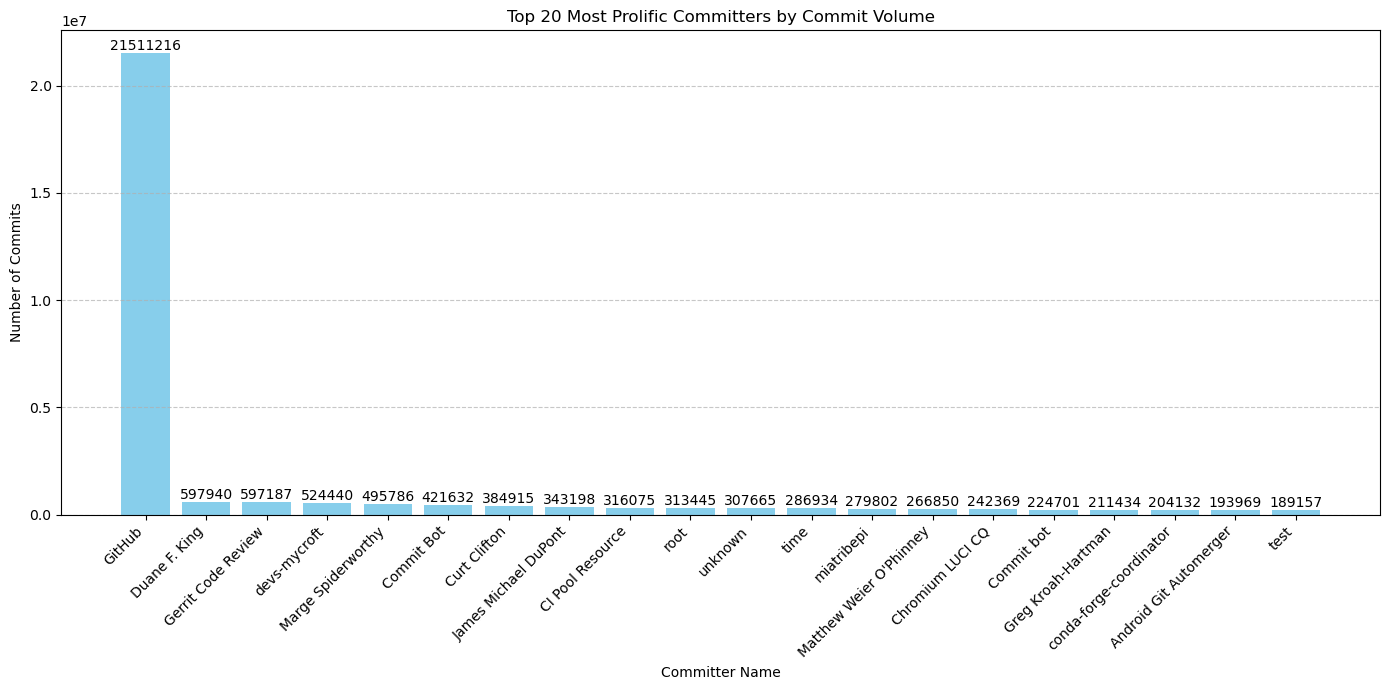

Image saved to Google Cloud Storage: gs://dema-bdp-student/most_prolific_committers.png


<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import io
from google.cloud import storage

# Plotting
plt.figure(figsize=(14, 7))
bars = plt.bar(committers, commit_counts, color='skyblue')  # Plotting top 20 committers for readability
plt.xlabel('Committer Name')
plt.ylabel('Number of Commits')
plt.title('Top 20 Most Prolific Committers by Commit Volume')
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap

# Add text annotations to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom')

# Display the plot
plt.show()

In [21]:
import matplotlib.pyplot as plt
import io
from google.cloud import storage

# Plotting
plt.figure(figsize=(14, 7))
bars = plt.bar(committers, commit_counts, color='skyblue')  # Plotting top 20 committers for readability
plt.xlabel('Committer Name')
plt.ylabel('Number of Commits')
plt.title('Top 20 Most Prolific Committers by Commit Volume')
plt.xticks(rotation=45, ha='right')  # Rotate and align the x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap

# Add text annotations to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom')

# Save the plot as an image in memory
image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)

# Upload the image to Google Cloud Storage
client = storage.Client()
bucket = client.bucket('dema-bdp-student')
blob = bucket.blob('most_prolific_committers.png')
blob.upload_from_file(image_buffer, content_type='image/png')

# Close the plot to free up memory
plt.close()

# Display a message
print("Image saved to Google Cloud Storage: gs://dema-bdp-student/most_prolific_committers.png")


Image saved to Google Cloud Storage: gs://dema-bdp-student/most_prolific_committers.png
